# 11. 연속적인 상태 공간 (Continuous Observation Spaces)

이번 챕터에서는 **Mountain Car** 환경을 예제로 사용하여, 연속적인 상태 공간을 다루는 테이블 기반 방법론을 학습한다.
연속적인 상태를 다루기 위해 다음과 같은 두 가지 방법을 구현하고 비교해 본다.

1. **상태 압축 (State Aggregation):** 상태 공간을 격자(Grid)로 나누어 각각을 하나의 상태로 취급한다.
2. **타일 코딩 (Tile Coding):** 여러 개의 겹쳐진 격자(Tilings)를 사용하여 정보를 더 정밀하게 표현하고 일반화(Generalization) 성능을 높인다.

### 0. 라이브러리 및 헬퍼 함수 설정

최신 버전인 `gymnasium`을 사용하며, 시각화와 학습에 필요한 함수들을 미리 정의한다.

In [4]:
%pip install -q tqdm

Note: you may need to restart the kernel to use updated packages.


In [5]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# Jupyter Notebook 내 시각화 설정
%matplotlib inline

In [6]:
# 시드 고정 함수
def seed_everything(env, seed=42):
    np.random.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

# 가치 함수(Cost-to-Go) 시각화 함수
def plot_tabular_cost_to_go(action_values, xlabel, ylabel):
    # 각 상태의 최대 가치(Max Q) 계산
    if len(action_values.shape) == 4: # Tile Coding의 경우 (Tilings, Dim1, Dim2, Action)
        values = np.max(action_values.mean(axis=0), axis=2)
    else: # State Aggregation의 경우 (Dim1, Dim2, Action)
        values = np.max(action_values, axis=2)

    # -Max Q를 Cost로 변환 (Mountain Car는 보상이 음수이므로, -Max Q는 Cost-to-Go와 유사)
    cost_values = -values

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    x = np.arange(cost_values.shape[0])
    y = np.arange(cost_values.shape[1])
    X, Y = np.meshgrid(y, x) # X, Y 축 매핑 주의

    surf = ax.plot_surface(X, Y, cost_values, cmap='viridis', edgecolor='none')
    ax.set_xlabel(ylabel)
    ax.set_ylabel(xlabel)
    ax.set_zlabel('Cost (-Max Q)')
    ax.set_title('Cost to Go Function')
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

# 학습 통계 시각화 함수
def plot_stats(stats):
    plt.figure(figsize=(10, 5))
    plt.plot(stats['Returns'])
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("Episode Returns over Time")
    plt.show()

# 에이전트 테스트 함수
def test_agent(env, policy, episodes=3):
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        step = 0
        img = plt.imshow(env.render())
        plt.axis('off')
        plt.title(f"Test Episode {ep+1}")

        while not done:
            action = policy(state, epsilon=0.0) # Greedy
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            img.set_data(env.render())
            plt.pause(0.01) # 애니메이션 효과
            step += 1
        print(f"Episode {ep+1} finished in {step} steps.")
    plt.close()

---

## 1. 상태 압축 (State Aggregation) 구현

상태 압축은 연속적인 상태 공간을 일정한 크기의 버킷(Bucket) 또는 빈(Bin)으로 나누어 이산화하는 가장 직관적인 방법이다. 예를 들어 위치를 20등분, 속도를 20등분 하면 총 400개의 이산 상태가 생성된다.

### 1.1 환경 생성

MountainCar-v0 환경을 생성하고, 상태 공간의 범위(최솟값, 최댓값)를 확인한다.

In [7]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')
seed_everything(env)

print(f"Observation Space: {env.observation_space}")
print(f"Low: {env.observation_space.low}")
print(f"High: {env.observation_space.high}")

Observation Space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Low: [-1.2  -0.07]
High: [0.6  0.07]


### 1.2 상태 압축 래퍼 (Wrapper) 생성

`gymnasium.ObservationWrapper`를 상속받아, 연속적인 상태를 입력받아 이산적인 인덱스로 변환해주는 래퍼 클래스를 정의한다.

In [8]:
class StateAggregationEnv(gym.ObservationWrapper):
    def __init__(self, env, bins, low, high):
        super().__init__(env)
        self.bins = bins
        self.low = low
        self.high = high
        # 이산화된 상태 공간 정의 (MultiDiscrete)
        self.observation_space = gym.spaces.MultiDiscrete(bins)

        # 각 차원별로 구간(Bucket) 생성
        # np.linspace로 경계선을 만들고, np.digitize로 인덱스를 찾음
        self.buckets = [np.linspace(l, h, b - 1) for l, h, b in zip(low, high, bins)]

    def observation(self, obs):
        # 연속적인 관측값을 해당 버킷의 인덱스로 변환
        indices = tuple(np.digitize(x, b) for x, b in zip(obs, self.buckets))
        return indices

# 래퍼 적용 (20x20 그리드)
bins = np.array([20, 20])
low = env.observation_space.low
high = env.observation_space.high
saenv = StateAggregationEnv(env, bins=bins, low=low, high=high)

print(f"Modified observation space: {saenv.observation_space}")
print(f"Sample state (discrete): {saenv.observation_space.sample()}")

Modified observation space: MultiDiscrete([20 20])
Sample state (discrete): [14 15]


### 1.3 Q-테이블 및 정책 정의

이산화된 상태 공간 `(20, 20)`에 행동 공간 `(3)`을 더해 `(20, 20, 3)` 크기의 Q-테이블을 생성한다.

In [9]:
# Q-테이블 초기화
action_values = np.zeros((20, 20, 3))

# Epsilon-Greedy 정책
def policy(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        # 상태에 해당하는 Q값들 가져오기
        av = action_values[state]
        # 최대 Q값을 가진 행동 선택 (동점시 랜덤)
        return np.random.choice(np.flatnonzero(av == av.max()))

### 1.4 SARSA 알고리즘으로 학습

상태 압축 환경에서 SARSA 알고리즘을 사용하여 학습을 진행한다.

Training with State Aggregation...


100%|██████████| 20000/20000 [04:08<00:00, 80.33it/s]


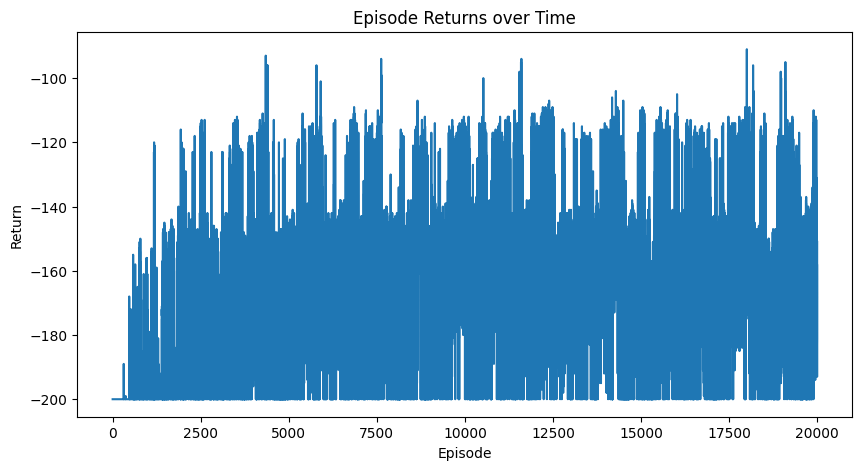

In [10]:
def sarsa(env, action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}

    for episode in tqdm(range(1, episodes + 1)):
        state, _ = env.reset()
        action = policy(state, epsilon)
        done = False
        total_return = 0

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            next_action = policy(next_state, epsilon)

            # SARSA 업데이트
            # Q(S, A) <- Q(S, A) + alpha * [R + gamma * Q(S', A') - Q(S, A)]
            q_val = action_values[state][action]
            next_q_val = action_values[next_state][next_action]

            target = reward + gamma * next_q_val
            action_values[state][action] += alpha * (target - q_val)

            state = next_state
            action = next_action
            total_return += reward

        stats['Returns'].append(total_return)

    return stats

# 학습 실행 (20,000 에피소드)
print("Training with State Aggregation...")
stats = sarsa(saenv, action_values, policy, episodes=20000, alpha=0.1, epsilon=0.1)
plot_stats(stats)

### 1.5 결과 시각화

학습된 가치 함수(Cost-to-Go)를 시각화하여, 에이전트가 어떤 상태를 좋게(또는 나쁘게) 평가하는지 확인한다.

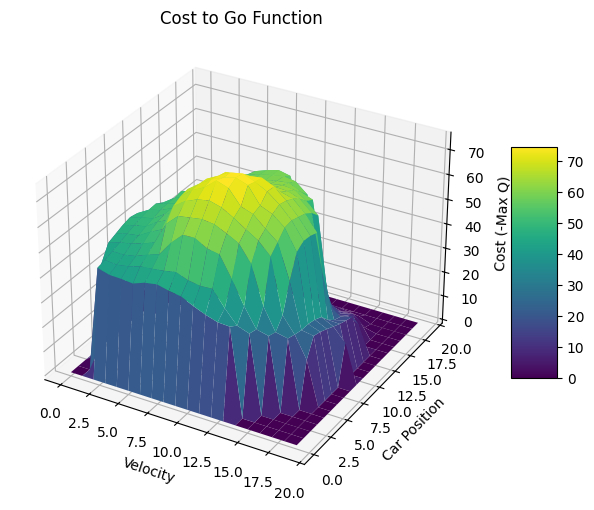

In [11]:
plot_tabular_cost_to_go(action_values, xlabel="Car Position", ylabel="Velocity")

---

## 2. 타일 코딩 (Tile Coding) 구현

상태 압축은 경계선 근처에서 정보가 급격하게 변하는 단점이 있다. **타일 코딩**은 서로 조금씩 어긋난 여러 개의 그리드(Tilings)를 겹쳐서 사용하여, 상태를 더 부드럽고 정밀하게 표현하는 기법이다.

### 2.1 타일 코딩 래퍼 (Wrapper) 생성

여러 개의 타일링(Tilings)을 생성하고, 입력 상태를 각 타일링에서의 인덱스로 변환하는 래퍼를 정의한다.

In [12]:
class TileCodingEnv(gym.ObservationWrapper):
    def __init__(self, env, bins, low, high, n=4):
        super().__init__(env)
        self.n = n # 타일링 개수
        self.bins = bins
        self.low = low
        self.high = high
        # 상태 공간은 (n, bins[0], bins[1]) 형태가 됨
        # 하지만 Gym Space로는 표현하기 복잡하므로 내부적으로만 관리하고
        # observation 메서드에서 튜플 리스트를 반환하도록 함

        # 각 타일링별 오프셋(Offset) 생성
        # 각 차원의 구간 너비 계산
        self.tile_width = (high - low) / bins
        self.offsets = []
        for i in range(n):
            # 타일링마다 조금씩 위치를 이동시킴
            offset = (low + i * (self.tile_width / n))
            self.offsets.append(offset)

        # 각 타일링별 버킷 경계 생성
        self.tilings_buckets = []
        for i in range(n):
            # 오프셋만큼 이동된 경계선 생성
            # 주의: 상태가 범위를 벗어날 수 있으므로 넉넉하게 처리하거나 클리핑 필요
            # 여기서는 간단하게 linspace로 생성하되, 입력값 처리시 digitize가 알아서 처리함
            buckets = [np.linspace(l, h, b - 1) for l, h, b in zip(self.offsets[i], self.offsets[i] + (high-low), bins)]
            self.tilings_buckets.append(buckets)

    def observation(self, obs):
        # n개의 타일링 각각에 대해 인덱스를 계산
        indices = []
        for i in range(self.n):
            # i번째 타일링의 버킷을 이용해 인덱스 추출
            # 범위를 벗어나는 경우를 대비해 bins-1로 클리핑해주는 것이 안전함
            idx = tuple(np.clip(np.digitize(x, b), 0, bn - 1) for x, b, bn in zip(obs, self.tilings_buckets[i], self.bins))
            indices.append(idx)
        return tuple(indices)

# 래퍼 적용 (4개의 타일링 사용)
tilings = 4
bins = np.array([20, 20])
tcenv = TileCodingEnv(env, bins=bins, low=low, high=high, n=tilings)

# 샘플 상태 확인
state, _ = tcenv.reset()
print(f"Sample state (Tile Coding): {state}")
# 결과 예: ((idx1_x, idx1_v), (idx2_x, idx2_v), ...) 형태로 4개의 좌표가 나옴

Sample state (Tile Coding): ((np.int64(8), np.int64(10)), (np.int64(8), np.int64(9)), (np.int64(8), np.int64(9)), (np.int64(8), np.int64(9)))


### 2.2 Q-테이블 및 정책 정의

타일 코딩에서는 값을 **모든 타일링의 합(또는 평균)**으로 계산한다. 따라서 Q-테이블은 `(4, 20, 20, 3)` 형태가 된다.

In [13]:
# Q-테이블 초기화 (타일링 개수 차원 추가)
action_values_tc = np.zeros((tilings, 20, 20, 3))

# Tile Coding용 정책 함수
def policy_tc(state, epsilon=0.):
    if np.random.random() < epsilon:
        return np.random.randint(3)
    else:
        # 각 타일링에서 해당 상태의 Q값들을 가져와서 합산 (또는 평균)
        # state는 4개의 (x_idx, v_idx) 튜플을 담고 있음
        q_vals = np.zeros(3)
        for i, (r, c) in enumerate(state):
            q_vals += action_values_tc[i, r, c]

        return np.random.choice(np.flatnonzero(q_vals == q_vals.max()))

### 2.3 SARSA 알고리즘 (Tile Coding 버전)

Q값을 읽고 쓸 때 모든 타일링에 대해 연산을 수행하도록 SARSA 알고리즘을 수정한다.

Training with Tile Coding...


100%|██████████| 20000/20000 [10:17<00:00, 32.38it/s]


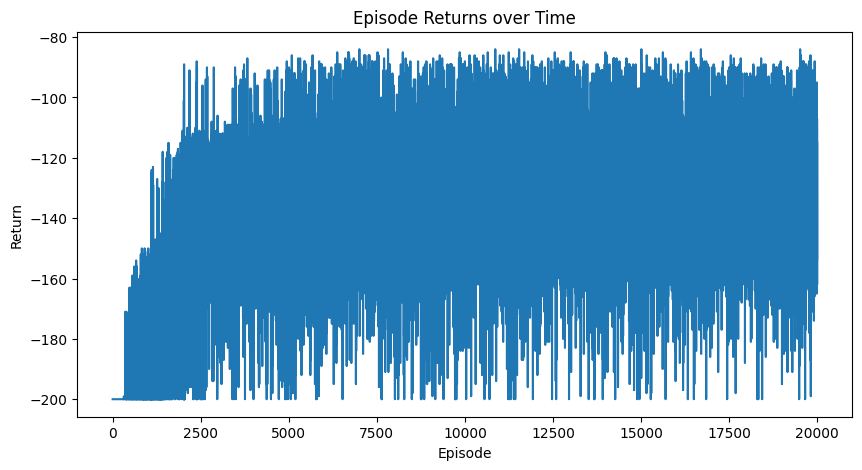

In [14]:
def sarsa_tc(env, action_values, policy, episodes, alpha=0.1, gamma=0.99, epsilon=0.2):
    stats = {'Returns': []}

    # Tile Coding에서는 여러 값을 업데이트하므로 학습률을 타일링 수로 나눠주기도 함
    alpha_tc = alpha / env.n

    for episode in tqdm(range(1, episodes + 1)):
        state, _ = env.reset()
        action = policy(state, epsilon)
        done = False
        total_return = 0

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            next_action = policy(next_state, epsilon)

            # 현재 상태의 Q값 (모든 타일링 합)
            current_q = 0
            for i, (r, c) in enumerate(state):
                current_q += action_values[i, r, c, action]

            # 다음 상태의 Q값 (모든 타일링 합)
            next_q = 0
            for i, (r, c) in enumerate(next_state):
                next_q += action_values[i, r, c, next_action]

            # TD Target
            target = reward + gamma * next_q
            td_error = target - current_q

            # 모든 타일링의 Q값 업데이트
            # 각 타일링이 전체 에러의 일부(alpha_tc)만큼 보정
            for i, (r, c) in enumerate(state):
                action_values[i, r, c, action] += alpha_tc * td_error

            state = next_state
            action = next_action
            total_return += reward

        stats['Returns'].append(total_return)

    return stats

# 학습 실행
print("Training with Tile Coding...")
stats_tc = sarsa_tc(tcenv, action_values_tc, policy_tc, episodes=20000, alpha=0.1, epsilon=0.1)
plot_stats(stats_tc)

### 2.4 결과 비교 및 시각화

타일 코딩을 사용했을 때의 가치 함수를 시각화한다. 상태 압축에 비해 더 부드러운 곡면을 형성하는 것을 볼 수 있다. 이는 일반화(Generalization)가 더 잘 이루어졌음을 의미한다.

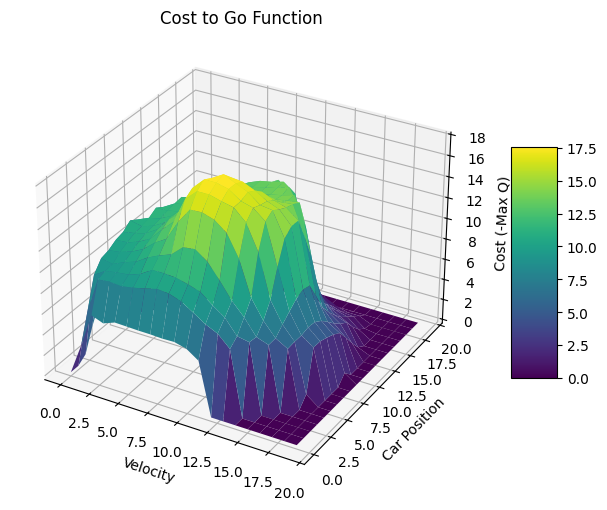

In [15]:
# 평균 Q값을 이용해 시각화
plot_tabular_cost_to_go(action_values_tc, xlabel="Car Position", ylabel="Velocity")

### 요약

연속적인 상태 공간을 다룰 때, 단순한 상태 압축보다는 **타일 코딩**이 더 효율적인 학습과 일반화를 가능하게 한다. 타일 코딩은 여러 개의 겹쳐진 격자를 통해 상태를 표현함으로써, 적은 수의 파라미터로도 정밀한 제어를 할 수 있게 해주는 강력한 기법이다. 현대의 딥러닝(DQN 등)이 등장하기 전까지 가장 널리 쓰이던 함수 근사 방법 중 하나다.